
The meaning of the class labels are as follows:
- 0: not part of the experiment. For instance the sensors are installed on the user or the user is performing activities unrelated to the experimental protocol, such as debriefing
- 1: experiment, no freeze (can be any of stand, walk, turn)
- 2: freeze 

In [114]:
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import glob, os

import tensorflow as tf
print(tf.__version__)
from keras.layers import BatchNormalization

from tensorflow import keras
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

2.4.1


In [2]:
plt.rcParams["figure.figsize"] = (20,10)

# import files for each recording

In [3]:
participant_file_names = []
participants = []

for file in glob.glob("*.txt"):
    # print(file)
    participant_file_names.append(np.genfromtxt(file, delimiter=''))
    participants.append(np.genfromtxt(file, delimiter=''))

S10R01.txt
S02R01.txt
S02R02.txt
S06R01.txt
S06R02.txt
S08R01.txt
S04R01.txt
S01R01.txt
S01R02.txt
S03R02.txt
S03R03.txt
S03R01.txt
S07R02.txt
S07R01.txt
S09R01.txt
S05R01.txt
S05R02.txt


In [4]:
len(participants)

17

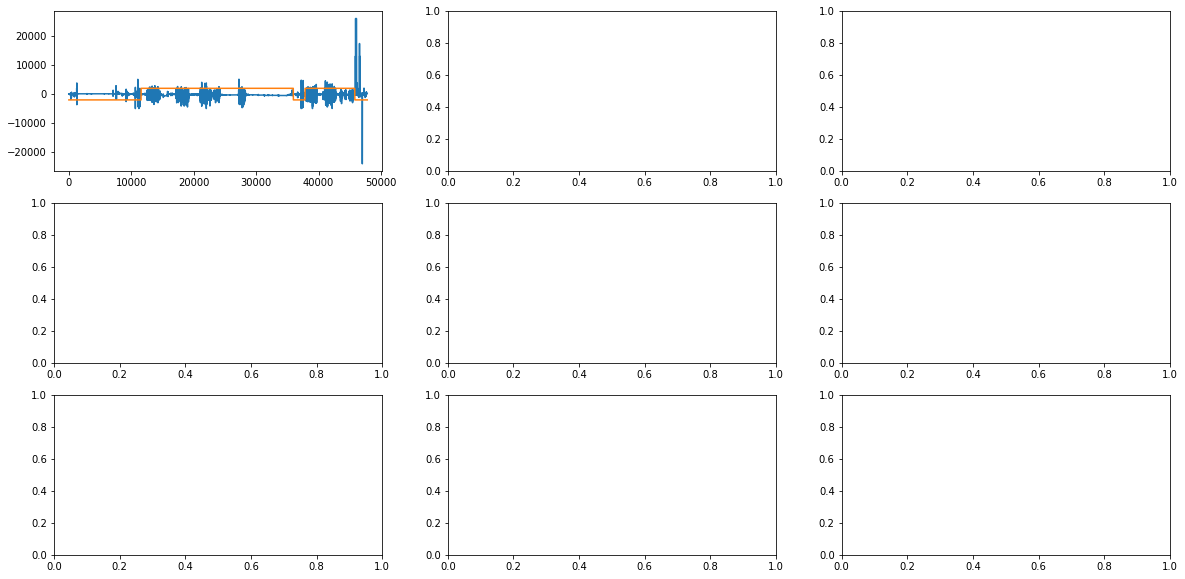

In [426]:
idx = 6
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3)
ax1.plot(participants[idx][:, 0]*(1.0/64), participants[idx][:, 1])
ax1.plot(participants[idx][:, 0]*(1.0/64), 4000*participants[idx][:, -1]-2000)
# ax2.plot(participants[idx][:, 0], participants[7][:, 2])
# ax2.plot(participants[7][:, 0], 4000*participants[7][:, -1]-2000)
# ax3.plot(participants[7][:, 0], participants[7][:, 3])
# ax3.plot(participants[7][:, 0], 4000*participants[7][:, -1]-2000)
# ax4.plot(participants[7][:, 0], participants[7][:, 4])
# ax4.plot(participants[7][:, 0], 4000*participants[7][:, -1]-2000)
# ax5.plot(participants[7][:, 0], participants[7][:, 5])
# ax5.plot(participants[7][:, 0], 4000*participants[7][:, -1]-2000)
# ax6.plot(participants[7][:, 0], participants[7][:, 6])
# ax6.plot(participants[7][:, 0], 4000*participants[7][:, -1]-2000)
# ax7.plot(participants[7][:, 0], participants[7][:, 7])
# ax7.plot(participants[7][:, 0], 4000*participants[7][:, -1]-2000)
# ax8.plot(participants[7][:, 0], participants[7][:, 8])
# ax8.plot(participants[7][:, 0], 4000*participants[7][:, -1]-2000)

(250000, 270000)

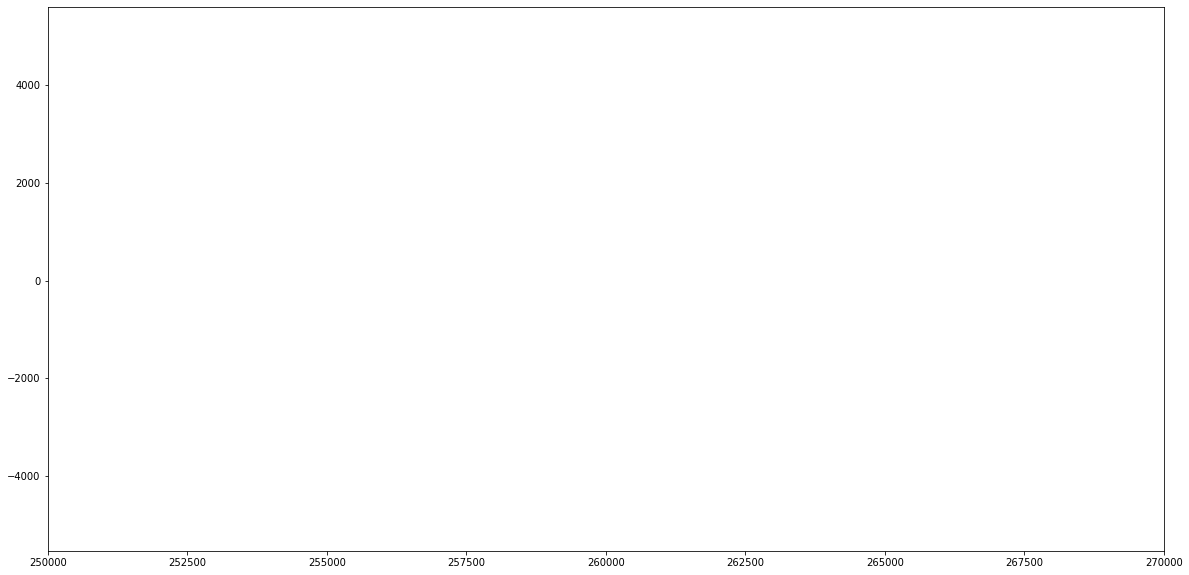

In [459]:
plt.plot(participants[7][:, 0]*(1.0/64), participants[7][:, 1])
plt.plot(participants[7][:, 0]*(1.0/64), 4000*participants[7][:, -1]-4000)
plt.xlim(250000, 270000)

# data were captured at average of 64 Hz

In [7]:
1000/(participants[7][4, 0] - participants[7][3, 0])

62.5

# In this study there were three sensors each having x, y, z measurements

There were 17 participants

we will use a sliding windows to create our window of prior observations in the time series data with which to predict the current class.

We will concatenate the windows for each participant

We will train and validate our model on data using the first 15 participants and test our model on the last 2 participants

In [297]:
#randomize order of participants
pari

In [427]:
len(participants)


17

In [373]:
# Make a function to window the data
window_size = 256

In [395]:
def series_to_supervised(participant_list, window_size=256):
    x, y, z = [], [], []
    class_ = []
    for k in range(len(participant_list)):
        participant = pd.DataFrame(participant_list[k])

        participant.columns = ["time", "x1", "y1", "z1", "x2", "y2", "z2", "x3", "y3", "z3", "class"]
        
        participant.drop(participant[(participant['class'] == 0)].index, inplace=True) 
        x_participant = pd.concat([participant['x1'].shift(i) for i in range(window_size, 0, -1)], axis=1).dropna()
        y_participant = pd.concat([participant['y1'].shift(i) for i in range(window_size, 0, -1)], axis=1).dropna()
        z_participant = pd.concat([participant['z1'].shift(i) for i in range(window_size, 0, -1)], axis=1).dropna()

        x.append(x_participant)
        y.append(y_participant)
        z.append(z_participant)

        class_.append(participant['class'][window_size:])

    class_ = pd.concat(class_)
    
    x = np.vstack(x)
    y = np.vstack(y)
    z = np.vstack(z)
    X = np.stack((x, y, z), axis=2)
    
    X = X.squeeze()
    
    y = class_
    
    return X, y

In [428]:
X, y = series_to_supervised(participants)

In [429]:
X.shape

(1136483, 256, 3)

# Split into train and test and stratify on y so the same proportion of classes are in train and test

In [442]:
X_train_inds, X_test_inds, y_train, y_test = train_test_split(np.arange(X.shape[0]), y, test_size=0.2, random_state=42,stratify=y)

In [443]:
X_train = X[X_train_inds, :, :]
X_test= X[X_test_inds, :, :]

In [444]:
X_train_inds, X_val_inds, y_train, y_val = train_test_split(np.arange(X_train.shape[0]), y_train, test_size=0.2, random_state=42,stratify=y_train)

In [445]:
X_train, X_val = X_train[X_train_inds, :, :], X_train[X_val_inds, :, :]


# Look at the class distribution

In [450]:
df = pd.DataFrame(y_test).reset_index()
df.columns= ['index', 'target']

Proportion class 1.0:0.9025
Proportion class 2.0:0.0975


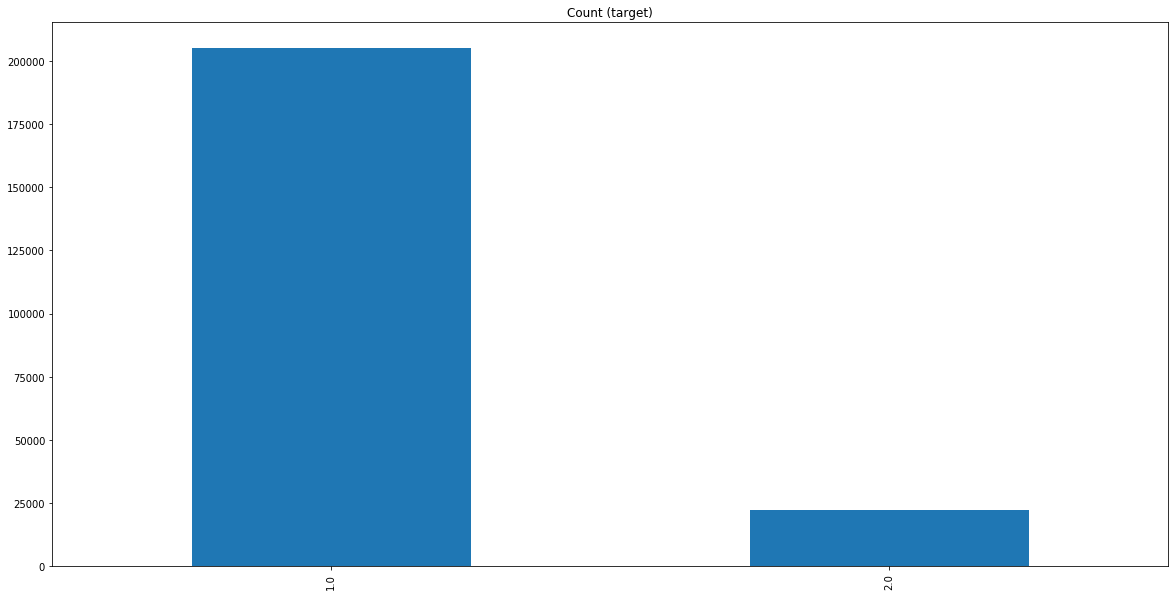

In [451]:
target_count = df.target.value_counts()
for index, row in target_count.items():
    print('Proportion class {}:{}'.format(index, round(row / np.sum(target_count), 4)))

target_count.plot(kind='bar', title='Count (target)');

## Oversample the minority class using imblearn so all classes are represented when making the decision function

In [400]:
# from imblearn.under_sampling import RandomUnderSampler

# undersample = RandomUnderSampler(random_state=0)
# X_rus, y_rus = undersample.fit_resample(X[:, :, 0], y)


In [401]:
#X_ = X[undersample.sample_indices_, :, :]

In [402]:
#y_ = y_rus

In [403]:
# X_ = X
# y_ = y

In [404]:
# from collections import Counter
# # print(sorted(Counter(y_).items()))

[(1.0, 922814), (2.0, 80415)]


Proportion class 1.0:0.9198
Proportion class 2.0:0.0802


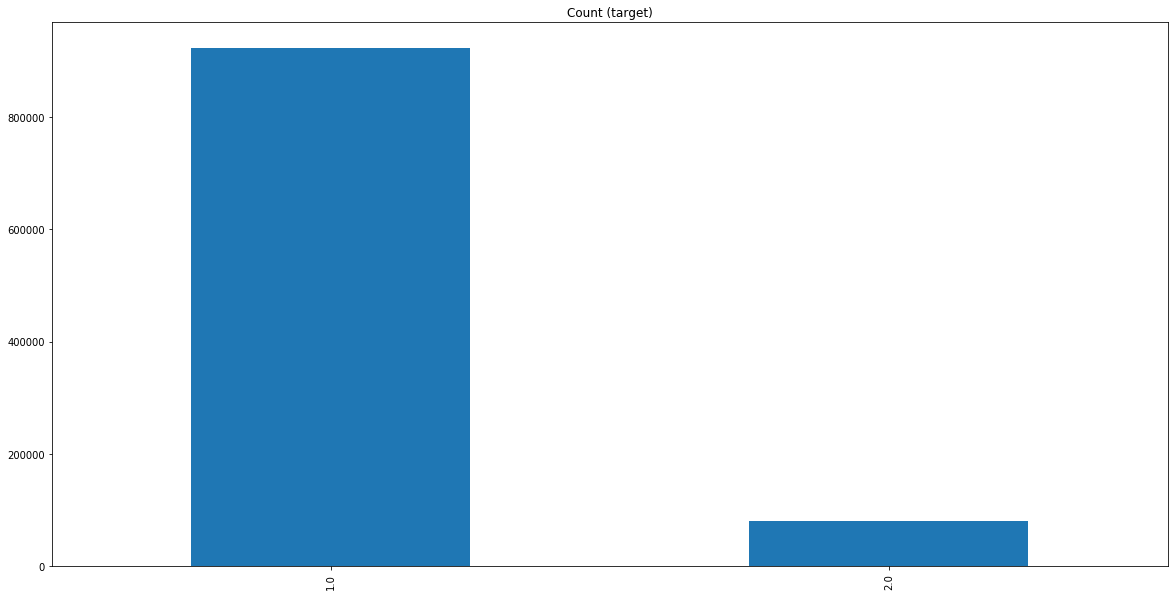

In [405]:
# target_count = y_.value_counts()
# for index, row in target_count.items():
#     print('Proportion class {}:{}'.format(index, round(row / np.sum(target_count), 4)))

# target_count.plot(kind='bar', title='Count (target)');

In [452]:
# encode class values as integers
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(encoded_Y)

encoded_Y = encoder.fit_transform(y_val)
# convert integers to dummy variables (i.e. one hot encoded)
y_val = to_categorical(encoded_Y)


In [453]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Define a 1D CNN model to find the function mapping each set of x, y, z accelerometer windows into an associated class label

In [454]:
n_filters = 32
filter_size = 5
pool_size = 2

In [455]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [456]:
tf.keras.backend.clear_session()
num_sensors = 3


## define the CNN model

In [457]:
tf.random.set_seed(1)

model = tf.keras.models.Sequential([
    #tf.keras.Input(input_shape=(TIME_PERIODS,num_sensors)),
    tf.keras.layers.Reshape((window_size,  num_sensors), input_shape=(window_size, num_sensors)),
    BatchNormalization(),
    tf.keras.layers.Conv1D(n_filters, filter_size, activation='relu', 
                           padding='same',input_shape=(window_size, num_sensors),
                          name='conv1'),
    tf.keras.layers.Conv1D(n_filters, filter_size, padding='same', 
                           activation='relu', name='conv2'),
    tf.keras.layers.MaxPooling1D(pool_size, name='maxpool'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])
 
    
#model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)


print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 256, 3)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 3)            12        
_________________________________________________________________
conv1 (Conv1D)               (None, 256, 32)           512       
_________________________________________________________________
conv2 (Conv1D)               (None, 256, 32)           5152      
_________________________________________________________________
maxpool (MaxPooling1D)       (None, 128, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               4

In [458]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # early stopping. Stop training based 
                                                                            # on your measured validation loss to 
                                                                            # catch your model just as it’s about 
                                                                            # to overfit.
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=64, 
                    callbacks=[callback], verbose=1)


Epoch 1/20
11365/11365 [==============================] - 387s 34ms/step - loss: 0.1462 - tp: 343089.5416 - fp: 20654.4506 - tn: 343089.5416 - fn: 20654.4506 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9861 - prc: 0.9861 - val_loss: 0.0692 - val_tp: 176941.0000 - val_fp: 4897.0000 - val_tn: 176941.0000 - val_fn: 4897.0000 - val_accuracy: 0.9731 - val_precision: 0.9731 - val_recall: 0.9731 - val_auc: 0.9970 - val_prc: 0.9970
Epoch 2/20
11365/11365 [==============================] - 413s 36ms/step - loss: 0.0675 - tp: 354436.3122 - fp: 9306.9700 - tn: 354437.0223 - fn: 9307.6801 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9969 - prc: 0.9968 - val_loss: 0.0550 - val_tp: 178046.0000 - val_fp: 3792.0000 - val_tn: 178046.0000 - val_fn: 3792.0000 - val_accuracy: 0.9791 - val_precision: 0.9791 - val_recall: 0.9791 - val_auc: 0.9978 - val_prc: 0.9976
Epoch 3/20
11365/11365 [==============================] - 433s 38ms/step - loss: 0.0442 - tp: 358039.909

## It seems our model performs equally well on the train and validation.
The fitting is stopped when the validation loss no longer decreases

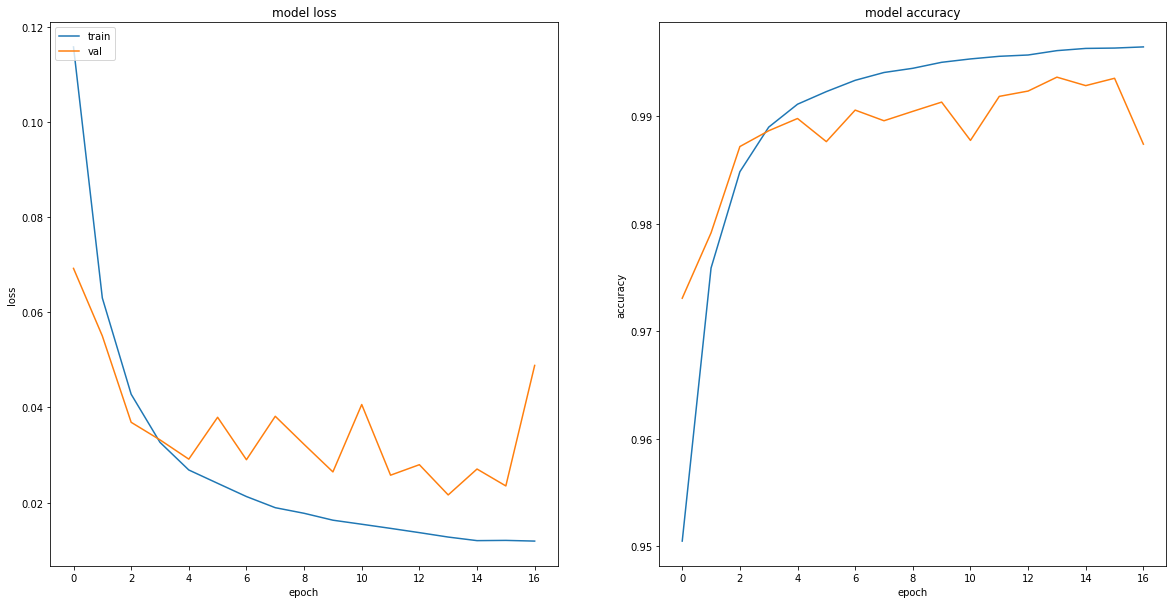

In [460]:
# summarize history for loss and accuracy
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 10])
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
plt.show()

In [461]:

encoded_Y = encoder.fit_transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_test = to_categorical(encoded_Y)

## Now test on the held out test set and evaluate our test predictions using a confusion matrix

In [462]:
from sklearn.metrics import confusion_matrix

In [463]:
predictions = (model.predict(X_test) > 0.5).astype(int)


In [464]:
conf_mat = confusion_matrix(y_true=y_test.argmax(axis=1), y_pred=predictions.argmax(axis=1))
print('Confusion matrix:\n', np.round(conf_mat/np.sum(conf_mat, axis=0), 2))

Confusion matrix:
 [[1.   0.11]
 [0.   0.89]]


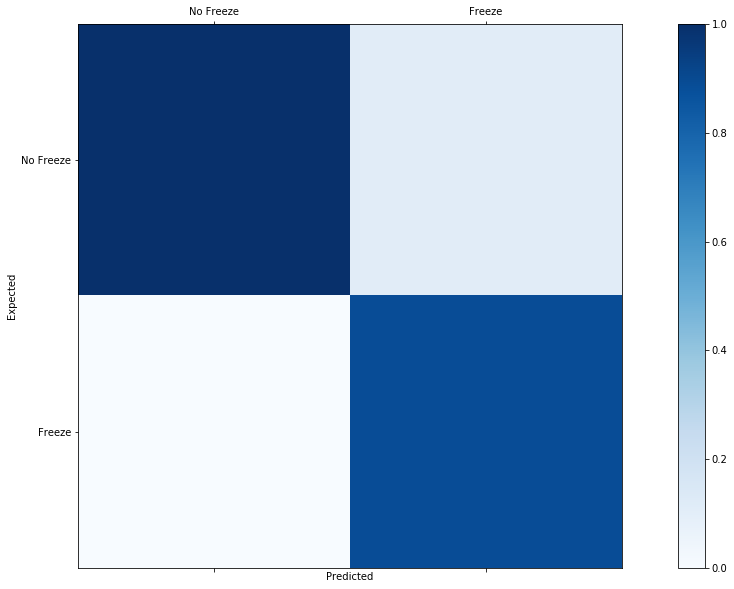

In [465]:
labels = ['No Freeze', 'Freeze']
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(111)
cax = ax.matshow(np.round(conf_mat/np.sum(conf_mat, axis=0), 2), cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# evaluate model with Average precision using PR AUC

In [466]:
y_prob = model.predict(X_test)

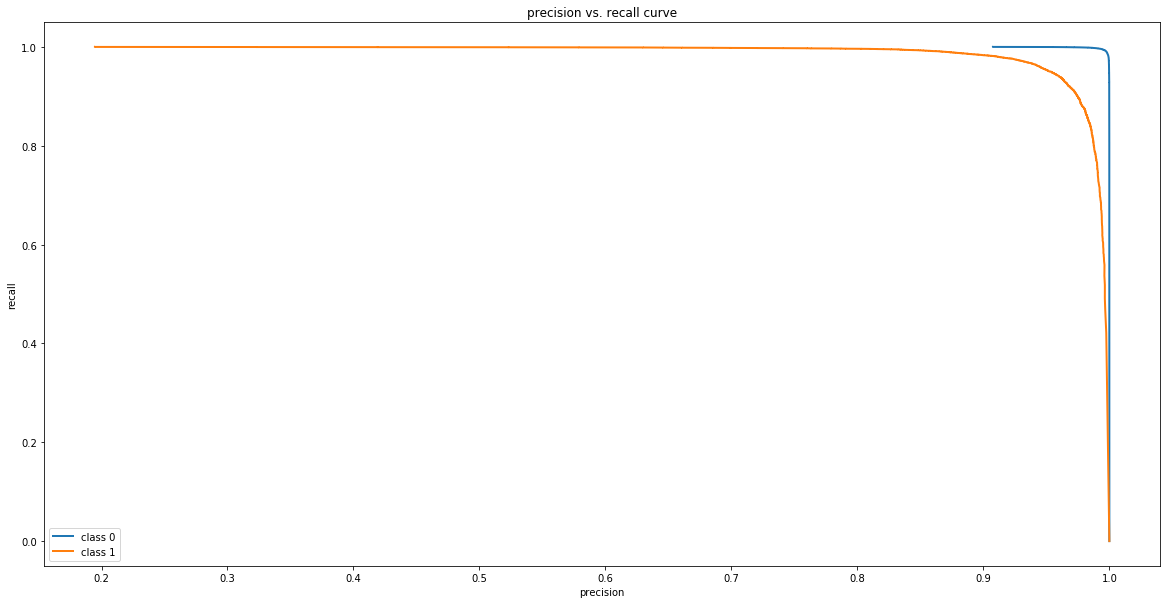

In [467]:
precision = dict()
recall = dict()
classes = [0, 1]
for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_prob[:, i])
    plt.plot(precision[i], recall[i], lw=2, label='class {}'.format(classes[i]))
    
plt.xlabel("precision")
plt.ylabel("recall")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [468]:
print(classification_report(y_true=y_test.argmax(axis=1), y_pred=predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    205140
           1       0.89      0.98      0.94     22157

    accuracy                           0.99    227297
   macro avg       0.95      0.99      0.97    227297
weighted avg       0.99      0.99      0.99    227297

